In [13]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации.
# 4. Вывести результат

In [14]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


Создание тестовой последовательности...
Генерация последовательности из 5 символов...
Успешно загружено: 5/5 изображений
Сгенерировано: w 3 4 - 2


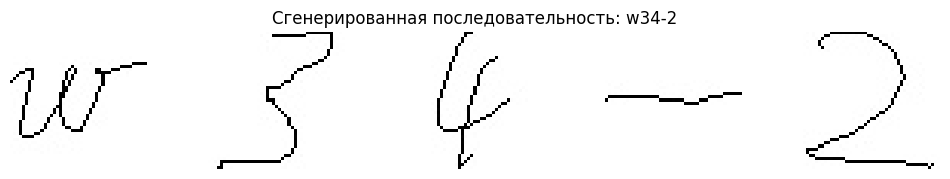

In [15]:
class HandwrittenSymbolsGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.symbols_data = {}
        self._load_symbols()

    def _load_symbols(self):
        folders = [f for f in os.listdir(self.data_path)
                  if os.path.isdir(os.path.join(self.data_path, f))]

        total_images = 0
        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []

            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    file_path = os.path.join(folder_path, filename)
                    images.append(file_path)

            if images:
                self.symbols_data[folder] = images
                total_images += len(images)

    def _load_image(self, image_path):
        with open(image_path, 'rb') as f:
                img_bytes = bytearray(f.read())
        img = cv2.imdecode(np.asarray(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)
        if img is not None:
            return img

    def generate_sequence(self, length=10):
        symbols = list(self.symbols_data.keys())

        sequence_images = []
        labels = []

        print(f"Генерация последовательности из {length} символов...")

        successful = 0
        attempts = 0
        max_attempts = length * 3

        while successful < length and attempts < max_attempts:
            symbol = random.choice(symbols)
            image_path = random.choice(self.symbols_data[symbol])
            image = self._load_image(image_path)

            if image is not None:
                sequence_images.append(image)
                labels.append(symbol)
                successful += 1


            attempts += 1

        print(f"Успешно загружено: {successful}/{length} изображений")

        sequence_image = self.create_sequence_image(sequence_images)
        print(f"Сгенерировано: {' '.join(labels)}")

        return {
            'sequence_images': sequence_images,
            'sequence_image': sequence_image,
            'labels': labels,
            'sequence_text': ''.join(labels),
            'length': length
        }

    def create_sequence_image(self, images, spacing=20):

        processed_images = []
        for img in images:
            if img is None:
                continue
            if len(img.shape) == 3:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                processed_images.append(gray_img)
            else:
                processed_images.append(img)

        total_width = sum(img.shape[1] for img in processed_images) + spacing * (len(processed_images) - 1)
        max_height = max(img.shape[0] for img in processed_images)

        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in processed_images:
            h, w = img.shape[:2]
            y_offset = (max_height - h) // 2
            sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + spacing

        return sequence_img

    def display_sequence(self, sequence_data, title="Сгенерированная последовательность"):
        plt.figure(figsize=(12, 3))
        plt.imshow(sequence_data['sequence_image'], cmap='gray')
        plt.title(f"{title}: {sequence_data['sequence_text']}")
        plt.axis('off')
        plt.show()

DATA_PATH = "./data"

generator = HandwrittenSymbolsGenerator(DATA_PATH)

print("\nСоздание тестовой последовательности...")
sequence_data = generator.generate_sequence(length=5)
generator.display_sequence(sequence_data)

In [16]:
class SequenceSegmenter:
    def segment_sequence(self, sequence_image, original_labels):
        print(f"Обрабатываем последовательность: {' '.join(original_labels)}")

        non_space_labels = [label for label in original_labels if label != ' ']
        print(f"Символы без пробелов: {non_space_labels}")

        img_gray = sequence_image
        kernel = np.ones((3,3),np.uint8)
        img_gray = cv2.erode(img_gray,kernel,iterations = 1)
        img_gray = cv2.bitwise_not(img_gray)

        base_size = img_gray.shape[0], img_gray.shape[1]
        base = np.zeros(base_size, dtype=np.uint8)
        base[0:img_gray.shape[0], 0:img_gray.shape[1]] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

        plt.figure(figsize=(10, 3))
        plt.imshow(base)
        plt.title(f'Последовательность: {" ".join(original_labels)}')
        plt.axis('off')
        plt.show()

        ret, thresh = cv2.threshold(base, 127, 255, 0)
        thresh = np.uint8(thresh)
        contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)

        contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
        crops = []

        img_with_boxes = base.copy()

        for i in range(len(contours_sorted)):
            cnt = contours_sorted[i]
            x, y, w, h = cv2.boundingRect(cnt)
            while (w > 45):
                w -= 1
            if w * h > 50:
                cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 0, 255), 1)
                crops.append([x, y, w, h])

        plt.figure(figsize=(10, 3))
        plt.imshow(img_with_boxes)
        plt.title('Обнаруженные контуры символов')
        plt.axis('off')
        plt.show()

        sequence_symbols = []
        for i in range(len(crops)):
            x, y, w, h = crops[i]

            img_crop = sequence_image[y:y+h, x:x+w]

            if i < len(non_space_labels):
                symbol_label = non_space_labels[i]
            else:
                symbol_label = "?"

            plt.figure(figsize=(3, 2))
            plt.imshow(img_crop, cmap="gray")
            plt.title(f'Символ {i+1}: "{symbol_label}"')
            plt.axis('off')
            plt.show()

            sequence_symbols.append((symbol_label, img_crop))
            print(f"Символ {i+1}: '{symbol_label}' ")

        return sequence_symbols

Генерация последовательности из 10 символов...
Успешно загружено: 10/10 изображений
Сгенерировано: 6 y 8 0 2 , 1 5 times 0
Обрабатываем последовательность: 6 y 8 0 2 , 1 5 times 0
Символы без пробелов: ['6', 'y', '8', '0', '2', ',', '1', '5', 'times', '0']


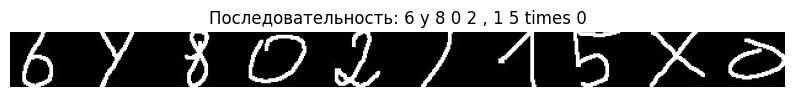

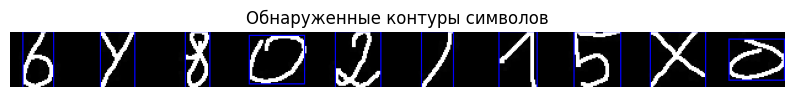

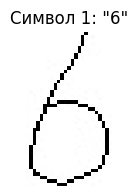

Символ 1: '6' 


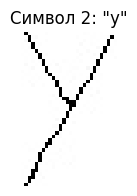

Символ 2: 'y' 


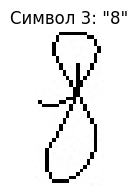

Символ 3: '8' 


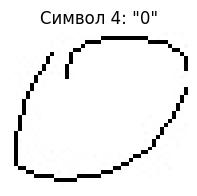

Символ 4: '0' 


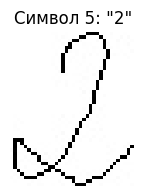

Символ 5: '2' 


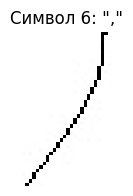

Символ 6: ',' 


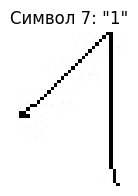

Символ 7: '1' 


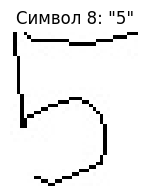

Символ 8: '5' 


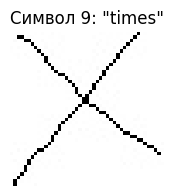

Символ 9: 'times' 


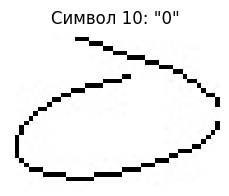

Символ 10: '0' 
Итог: сегментировано 10 символов


In [17]:
sequence_data = generator.generate_sequence(length=10)
sequence_image = sequence_data['sequence_image']
labels = sequence_data['labels']

segmenter = SequenceSegmenter()
segmented_symbols = segmenter.segment_sequence(sequence_image, labels)
print(f"Итог: сегментировано {len(segmented_symbols)} символов")


Подготовка сегментированных символов...

ОБРАБОТАННЫЕ СИМВОЛЫ (всего 10):


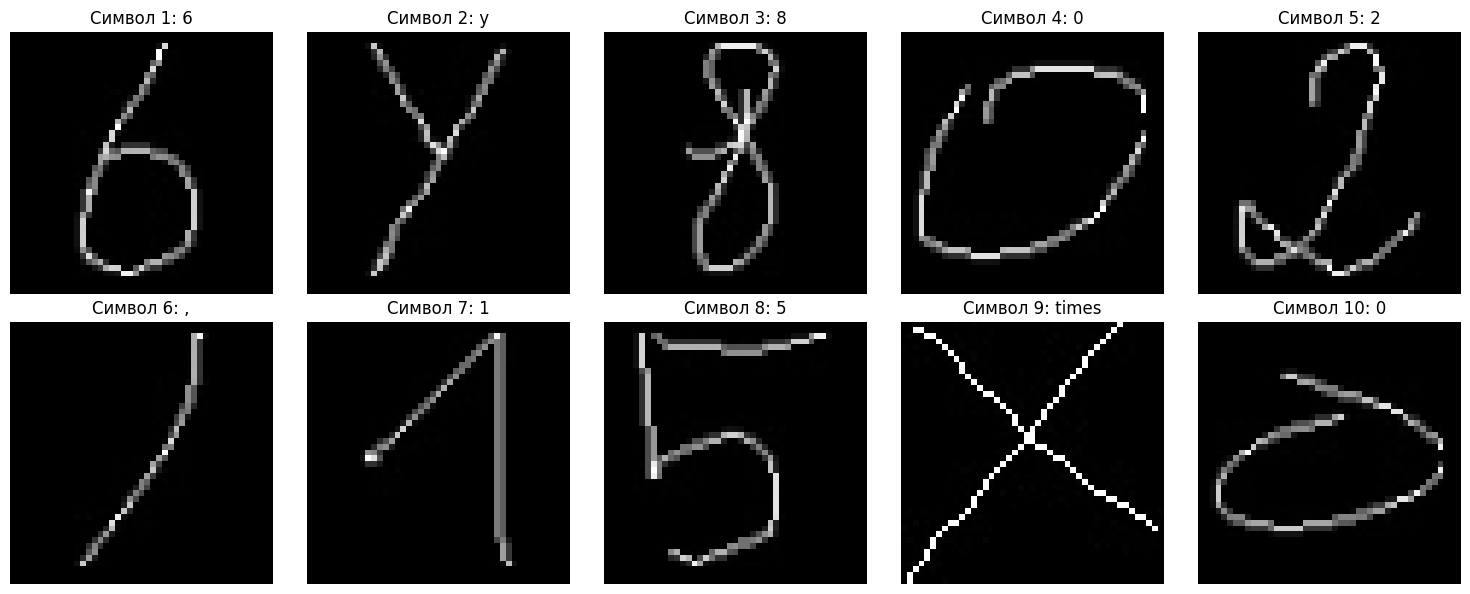


Загрузка тренировочных данных...
Загрузка данных из: ./data
Символы для загрузки: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', 'times', 'w', 'X', 'y']
  Символ '(': найдено 14294 изображений
  Символ ')': найдено 14355 изображений
  Символ '+': найдено 25112 изображений
  Символ ',': найдено 1906 изображений
  Символ '-': найдено 33997 изображений
  Символ '0': найдено 6914 изображений
  Символ '1': найдено 26520 изображений
  Символ '2': найдено 26141 изображений
  Символ '3': найдено 10909 изображений
  Символ '4': найдено 7396 изображений
  Символ '5': найдено 3545 изображений
  Символ '6': найдено 3118 изображений
  Символ '7': найдено 2909 изображений
  Символ '8': найдено 3068 изображений
  Символ '9': найдено 628 изображений
  Символ 'h': найдено 1464 изображений
  Символ 't': найдено 3274 изображений
  Символ 'times': найдено 3251 изображений
  Символ 'w': найдено 556 изображений
  Символ 'X': найдено 26594 изображений
  Символ 'y': най

In [18]:
def center_in_square(image, target_size=45):
    h, w = image.shape

    if h == target_size and w == target_size:
        return image

    squared = np.zeros((target_size, target_size), dtype=np.uint8)

    scale = min(target_size / h, target_size / w) * 0.9
    new_h, new_w = int(h * scale), int(w * scale)

    if new_h > 0 and new_w > 0:
        resized = cv2.resize(image, (new_w, new_h))
        y_offset = (target_size - new_h) // 2
        x_offset = (target_size - new_w) // 2
        squared[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    return squared


def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []

    print(f"Загрузка данных из: {data_path}")
    print(f"Символы для загрузки: {list(symbols)}")

    if not os.path.exists(data_path):
        print(f"ОШИБКА: Папка {data_path} не существует!")
        return X_train, y_train

    for symbol in symbols:
        symbol_path = os.path.join(data_path, str(symbol))  # Преобразуем в строку

        if not os.path.exists(symbol_path):
            continue

        try:
            images = [f for f in os.listdir(symbol_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        except PermissionError:
            print(f"  Ошибка доступа к папке: '{symbol_path}'")
            continue

        images.sort()

        print(f"  Символ '{symbol}': найдено {len(images)} изображений")

        if len(images) == 0:
            print(f"  Предупреждение: нет изображений для символа '{symbol}'")
            continue

        split_idx = min(int(len(images) * train_size), len(images))
        train_images = images[:split_idx]

        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_square(img)
                X_train.append(img_resized.flatten())
                y_train.append(symbol)
            else:
                print(f"    Не удалось загрузить: {img_path}")

    print(f"\nВсего загружено: {len(X_train)} изображений")
    print(f"Уникальные символы в тренировочных данных: {set(y_train)}")

    return X_train, y_train


print("\nПодготовка сегментированных символов...")
resized_symbols = []
for true_label, symbol_img in segmented_symbols:
    processed_img = cv2.bitwise_not(symbol_img)
    resized_img = center_in_square(processed_img)
    resized_symbols.append((true_label, resized_img))
symbols_data = resized_symbols

print(f"\nОБРАБОТАННЫЕ СИМВОЛЫ (всего {len(symbols_data)}):")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for j, (true_label, symbol_img) in enumerate(symbols_data):
    if j < 10:
        axes[j].imshow(symbol_img, cmap='gray')
        axes[j].set_title(f'Символ {j + 1}: {true_label}')
        axes[j].axis('off')

plt.tight_layout()
plt.show()

print("\nЗагрузка тренировочных данных...")
X_train, y_train = load_training_data(DATA_PATH, generator.symbols_data.keys())

if len(X_train) == 0:
    print("\nТренировочные данные пустые. Создаем данные из сегментированных символов...")
    for true_label, symbol_img in symbols_data:
        img_flat = symbol_img.flatten()
        X_train.append(img_flat)
        y_train.append(true_label)

    print("Добавляем аугментацию данных...")
    augmented_data = []
    for i, (true_label, symbol_img) in enumerate(symbols_data):
        img_flat = symbol_img.flatten()
        X_train.append(img_flat)
        y_train.append(true_label)

        rows, cols = symbol_img.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 2, 1)
        rotated = cv2.warpAffine(symbol_img, M, (cols, rows))
        X_train.append(rotated.flatten())
        y_train.append(true_label)
        M = np.float32([[1, 0, 1], [0, 1, 1]])
        shifted = cv2.warpAffine(symbol_img, M, (cols, rows))
        X_train.append(shifted.flatten())
        y_train.append(true_label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"\nРазмер тренировочных данных:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Уникальные символы: {np.unique(y_train)}")

if len(X_train) < 2:

    if os.path.exists(DATA_PATH):
        print("\nСодержимое папки данных:")
        for item in os.listdir(DATA_PATH):
            item_path = os.path.join(DATA_PATH, item)
            if os.path.isdir(item_path):
                images = [f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                print(f"  {item}/ - {len(images)} изображений")
    else:
        print(f"\nПапка {DATA_PATH} не существует!")
else:
    print("\nОбучение моделей KNN...")
    knn1 = KNeighborsClassifier(n_neighbors=1)
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn5 = KNeighborsClassifier(n_neighbors=5)
    knn7 = KNeighborsClassifier(n_neighbors=7)

    knn1.fit(X_train, y_train)
    knn3.fit(X_train, y_train)
    knn5.fit(X_train, y_train)
    knn7.fit(X_train, y_train)

    models = {
        'knn1': knn1,
        'knn3': knn3,
        'knn5': knn5,
        'knn7': knn7
    }

    results = {}

    for model_name, model in models.items():
        print(f"\n{'=' * 50}")
        print(f"МОДЕЛЬ: {model_name}")
        print(f"{'=' * 50}")

        predicted_symbols = []

        for j, (true_label, symbol_img) in enumerate(symbols_data):
            img_flat = symbol_img.flatten()
            predicted_char = model.predict([img_flat])[0]
            predicted_symbols.append(predicted_char)
            print(f"    Символ {j + 1}: ожидалось '{true_label}', предсказан '{predicted_char}'")

        predicted_text = ''.join(predicted_symbols)
        print(f"Предсказано: '{predicted_text}'")

        original_text_str = sequence_data['sequence_text']

        original_chars_no_spaces = [c for c in original_text_str if c != ' ']
        predicted_chars_no_spaces = predicted_symbols

        min_len = min(len(original_chars_no_spaces), len(predicted_chars_no_spaces))
        correct_chars = sum(1 for i in range(min_len) if original_chars_no_spaces[i] == predicted_chars_no_spaces[i])
        total_chars = len(original_chars_no_spaces)
        accuracy = correct_chars / total_chars if total_chars > 0 else 0

        if min_len > 0 and original_chars_no_spaces != predicted_chars_no_spaces:
            for idx in range(min_len):
                orig_char = original_chars_no_spaces[idx]
                pred_char = predicted_chars_no_spaces[idx]
                if orig_char != pred_char:
                    print(f"   Ошибка в позиции {idx + 1}: ожидалось '{orig_char}', получено '{pred_char}'")

        print(f"Accuracy для {model_name}: {accuracy:.2f} ({correct_chars}/{total_chars} символов)")

        results[model_name] = {
            'predicted_text': predicted_text,
            'accuracy': accuracy,
            'correct_chars': correct_chars,
            'total_chars': total_chars
        }

    print(f"\n{'=' * 60}")
    print("ИТОГИ ПО ВСЕМ МОДЕЛЯМ:")
    print(f"{'=' * 60}")

    sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    for model_name, result in sorted_results:
        accuracy_percent = result['accuracy'] * 100
        print(
            f"{model_name:5} | Accuracy: {accuracy_percent:6.2f}% | {result['correct_chars']}/{result['total_chars']} | Предсказание: '{result['predicted_text']}'")